# 05 — Data Augmentation

Augmentasi data ABSA untuk mengatasi **class imbalance** dan **data scarcity**.

**PENTING**: Split train/val dilakukan **SEBELUM** augmentasi untuk mencegah data leakage.
Augmentasi hanya diterapkan pada **training set**. Val set tetap original.

Distribusi aspek saat ini (sangat imbalanced):

| Sentiment | Kalimat | % |
|-----------|---------|---|
| POS | 2,036 | 83.1% |
| NEU | 625 | 25.5% |
| NEG | 433 | 17.7% |

Teknik augmentasi (ABSA-safe, preserve token-label alignment):
1. **Oversampling** — duplicate kalimat NEG (3x) dan NEU (2x)
2. **Random O-token deletion** — hapus 1-2 token O pada salinan
3. **Random O-token swap** — tukar posisi 2 token O bersebelahan
4. **Mention replacement** — ganti aspect term dengan aspect term lain (sentimen & panjang token sama)

In [1]:
import json
import os
import copy
import random
from collections import Counter, defaultdict

import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

SEED = 42
random.seed(SEED)

### 1. LOAD DATA & ANALISIS DISTRIBUSI AWAL

In [2]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')

INPUT_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
OUTPUT_TRAIN_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_augmented_train.json')
OUTPUT_VAL_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_val.json')

# Split config — MUST match NB 03/04/06
TRAIN_RATIO = 0.85

with open(INPUT_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f'Total samples: {len(data)}')
print(f'Sample format: {list(data[0].keys())}')

# === SPLIT TRAIN/VAL SEBELUM AUGMENTASI ===
# Menggunakan torch.randperm dengan seed yang sama persis seperti NB 03/04/06
total = len(data)
indices = torch.randperm(total, generator=torch.Generator().manual_seed(SEED))
split = int(total * TRAIN_RATIO)

train_indices = indices[:split].tolist()
val_indices = indices[split:].tolist()

train_data = [data[i] for i in train_indices]
val_data = [data[i] for i in val_indices]

print(f'\nSplit (seed={SEED}, ratio={TRAIN_RATIO}):')
print(f'  Train: {len(train_data)} samples')
print(f'  Val  : {len(val_data)} samples (TIDAK akan diaugmentasi)')
print(f'\nContoh train[0]:')
print(f'  tokens: {train_data[0]["tokens"][:8]}...')
print(f'  labels: {train_data[0]["labels"][:8]}...')

Total samples: 2451
Sample format: ['tokens', 'labels']

Split (seed=42, ratio=0.85):
  Train: 2083 samples
  Val  : 368 samples (TIDAK akan diaugmentasi)

Contoh train[0]:
  tokens: ['desa', 'adat', 'bali', 'dengan', 'udara', 'yang', 'sejuk', ',']...
  labels: ['O', 'O', 'O', 'O', 'S-POS', 'O', 'O', 'O']...


In [3]:
def get_sentiments(labels):
    """Extract unique sentiment types from BIEOS labels."""
    sentiments = set()
    for lab in labels:
        if lab != 'O':
            sentiments.add(lab.split('-', 1)[1])
    return sentiments

def categorize_samples(samples):
    """Categorize samples by which sentiments they contain."""
    has_pos, has_neg, has_neu = [], [], []
    no_aspect = []
    for i, d in enumerate(samples):
        sents = get_sentiments(d['labels'])
        if not sents:
            no_aspect.append(i)
            continue
        if 'POS' in sents:
            has_pos.append(i)
        if 'NEG' in sents:
            has_neg.append(i)
        if 'NEU' in sents:
            has_neu.append(i)
    return has_pos, has_neg, has_neu, no_aspect

# Analisis distribusi pada TRAIN set saja (yang akan diaugmentasi)
has_pos, has_neg, has_neu, no_aspect = categorize_samples(train_data)

print('=== DISTRIBUSI TRAIN SET (sebelum augmentasi) ===')
print(f'Total train samples: {len(train_data)}')
print(f'Kalimat dengan POS : {len(has_pos)} ({len(has_pos)/len(train_data)*100:.1f}%)')
print(f'Kalimat dengan NEG : {len(has_neg)} ({len(has_neg)/len(train_data)*100:.1f}%)')
print(f'Kalimat dengan NEU : {len(has_neu)} ({len(has_neu)/len(train_data)*100:.1f}%)')
print(f'Tanpa aspek        : {len(no_aspect)} ({len(no_aspect)/len(train_data)*100:.1f}%)')

# Token-level distribution (train only)
label_counts = Counter()
for d in train_data:
    for lab in d['labels']:
        if lab != 'O':
            sentiment = lab.split('-', 1)[1]
            label_counts[sentiment] += 1

print(f'\nAspect tokens (train):')
for sent in ['POS', 'NEG', 'NEU']:
    print(f'  {sent}: {label_counts[sent]}')

=== DISTRIBUSI TRAIN SET (sebelum augmentasi) ===
Total train samples: 2083
Kalimat dengan POS : 1719 (82.5%)
Kalimat dengan NEG : 373 (17.9%)
Kalimat dengan NEU : 544 (26.1%)
Tanpa aspek        : 0 (0.0%)

Aspect tokens (train):
  POS: 4713
  NEG: 941
  NEU: 1503


### 2. ASPECT TERM BANK

Kumpulkan semua aspect term dari dataset, kelompokkan berdasarkan **sentimen** dan **jumlah token**. Digunakan untuk mention replacement.

In [4]:
def extract_aspect_spans(tokens, labels):
    """Extract aspect spans as (start, end, sentiment, term_tokens)."""
    spans = []
    i = 0
    while i < len(labels):
        lab = labels[i]
        if lab.startswith('S-'):
            sentiment = lab.split('-', 1)[1]
            spans.append((i, i+1, sentiment, tuple([tokens[i]])))
            i += 1
        elif lab.startswith('B-'):
            sentiment = lab.split('-', 1)[1]
            start = i
            i += 1
            while i < len(labels) and (labels[i].startswith('I-') or labels[i].startswith('E-')):
                if labels[i].startswith('E-'):
                    i += 1
                    break
                i += 1
            spans.append((start, i, sentiment, tuple(tokens[start:i])))
        else:
            i += 1
    return spans

# Build aspect term bank dari TRAIN data saja (mencegah leakage dari val)
aspect_bank = defaultdict(lambda: defaultdict(list))

for d in train_data:
    spans = extract_aspect_spans(d['tokens'], d['labels'])
    for start, end, sentiment, term_tokens in spans:
        n_tokens = end - start
        if term_tokens not in aspect_bank[sentiment][n_tokens]:
            aspect_bank[sentiment][n_tokens].append(term_tokens)

print('=== ASPECT TERM BANK (dari train set) ===')
for sentiment in ['POS', 'NEG', 'NEU']:
    total = sum(len(v) for v in aspect_bank[sentiment].values())
    print(f'\n{sentiment} ({total} unique terms):')
    for n_tok in sorted(aspect_bank[sentiment].keys()):
        terms = aspect_bank[sentiment][n_tok]
        examples = [' '.join(t) for t in terms[:5]]
        print(f'  {n_tok}-token: {len(terms)} terms  (e.g. {", ".join(examples)}{"..." if len(terms) > 5 else ""})')

=== ASPECT TERM BANK (dari train set) ===

POS (902 unique terms):
  1-token: 271 terms  (e.g. udara, penduduk, desa, tempat, warung...)
  2-token: 324 terms  (e.g. ruang ganti, liburan keluarga, tempat wisata, sewa pelampung, kamar mandi...)
  3-token: 168 terms  (e.g. harga tiket masuk, harga tiket masuknya, rumah tongkonan tua, baju dan pakaian, makanan dan minuman...)
  4-token: 73 terms  (e.g. harga makanan dan snack, belanja oleh - oleh, jalan akses ke lokasi, penataan dan pengelolaan pariwisatanya, cendera mata khas toraja...)
  5-token: 34 terms  (e.g. orang jual buah dan sayur, wisata untuk anak - anak, adat istiadat budaya suku toraja, jalan menuju kawasan kampung blekok, main dan berenang bersama ikan...)
  6-token: 19 terms  (e.g. ber foto di dalam air tawar, camping ground acara komunitas dan lainnya, harga makanan dan minuman , camilan, tempat oleh - oleh khas toraja, study tour atau kunjungan yang berkelompok...)
  7-token: 8 terms  (e.g. bersama keluarga , teman , maupu

### 3. FUNGSI AUGMENTASI

In [5]:
def random_o_deletion(sample, max_deletions=2):
    """Hapus 1-2 token berlabel O secara random.
    
    Hanya menghapus token O yang BUKAN di sebelah token aspek,
    supaya konteks aspek tetap terjaga.
    """
    tokens = list(sample['tokens'])
    labels = list(sample['labels'])
    
    # Cari posisi O yang aman untuk dihapus (tidak bersebelahan dengan aspek)
    safe_o_indices = []
    for i, lab in enumerate(labels):
        if lab != 'O':
            continue
        left_ok = (i == 0) or (labels[i-1] == 'O')
        right_ok = (i == len(labels)-1) or (labels[i+1] == 'O')
        if left_ok and right_ok:
            safe_o_indices.append(i)
    
    if len(safe_o_indices) < 2:
        return None
    
    n_delete = min(random.randint(1, max_deletions), len(safe_o_indices))
    to_delete = set(random.sample(safe_o_indices, n_delete))
    
    new_tokens = [t for i, t in enumerate(tokens) if i not in to_delete]
    new_labels = [l for i, l in enumerate(labels) if i not in to_delete]
    
    if len(new_tokens) < 3:
        return None
    
    return {'tokens': new_tokens, 'labels': new_labels}


def random_o_swap(sample, max_swaps=2):
    """Tukar posisi 2 token O yang bersebelahan."""
    tokens = list(sample['tokens'])
    labels = list(sample['labels'])
    
    swap_candidates = []
    for i in range(len(labels) - 1):
        if labels[i] == 'O' and labels[i+1] == 'O':
            if tokens[i] != tokens[i+1]:
                swap_candidates.append(i)
    
    if not swap_candidates:
        return None
    
    n_swaps = min(random.randint(1, max_swaps), len(swap_candidates))
    chosen = random.sample(swap_candidates, n_swaps)
    
    new_tokens = list(tokens)
    for i in chosen:
        new_tokens[i], new_tokens[i+1] = new_tokens[i+1], new_tokens[i]
    
    return {'tokens': new_tokens, 'labels': labels}


def mention_replacement(sample, aspect_bank):
    """Ganti aspect term dengan term lain yang sentimen & panjang token sama.
    
    Labels BIEOS tetap valid karena panjang span tidak berubah.
    """
    tokens = list(sample['tokens'])
    labels = list(sample['labels'])
    
    spans = extract_aspect_spans(tokens, labels)
    if not spans:
        return None
    
    # Pilih satu span secara random untuk di-replace
    span = random.choice(spans)
    start, end, sentiment, original_term = span
    n_tokens = end - start
    
    # Cari replacement dari bank
    candidates = aspect_bank.get(sentiment, {}).get(n_tokens, [])
    # Filter: jangan replace dengan term yang sama
    candidates = [c for c in candidates if c != original_term]
    
    if not candidates:
        return None
    
    replacement = random.choice(candidates)
    
    new_tokens = list(tokens)
    for i, new_tok in enumerate(replacement):
        new_tokens[start + i] = new_tok
    
    return {'tokens': new_tokens, 'labels': labels}


def augment_sample(sample, aspect_bank):
    """Terapkan salah satu augmentasi secara random.
    
    Distribusi: 30% O-deletion, 25% O-swap, 30% mention replacement, 15% exact copy
    """
    choice = random.random()
    if choice < 0.30:
        result = random_o_deletion(sample)
    elif choice < 0.55:
        result = random_o_swap(sample)
    elif choice < 0.85:
        result = mention_replacement(sample, aspect_bank)
    else:
        result = copy.deepcopy(sample)
    
    if result is None:
        result = copy.deepcopy(sample)
    
    return result

# Test semua teknik
test_sample = data[0]
print('Original:')
print(f'  tokens: {test_sample["tokens"]}')
print(f'  labels: {test_sample["labels"]}')

print('\n--- O-deletion ---')
r = random_o_deletion(test_sample)
if r: print(f'  tokens: {r["tokens"]}')
else: print('  (not applicable)')

print('\n--- O-swap ---')
r = random_o_swap(test_sample)
if r: print(f'  tokens: {r["tokens"]}')
else: print('  (not applicable)')

print('\n--- Mention replacement ---')
r = mention_replacement(test_sample, aspect_bank)
if r:
    print(f'  tokens: {r["tokens"]}')
    print(f'  labels: {r["labels"]}')
else:
    print('  (not applicable for this sample, trying another...)')
    for d in data[1:20]:
        r = mention_replacement(d, aspect_bank)
        if r:
            print(f'  original: {d["tokens"]}')
            print(f'  replaced: {r["tokens"]}')
            print(f'  labels  : {r["labels"]}')
            break

Original:
  tokens: ['banyak', 'hewan', 'blekok', 'nya']
  labels: ['O', 'B-NEU', 'E-NEU', 'O']

--- O-deletion ---
  (not applicable)

--- O-swap ---
  (not applicable)

--- Mention replacement ---
  tokens: ['banyak', 'tiket', 'masuk', 'nya']
  labels: ['O', 'B-NEU', 'E-NEU', 'O']


### 4. AUGMENTASI

In [6]:
# Konfigurasi oversampling
NEG_MULTIPLIER = 3  # Duplicate kalimat NEG 3x (total jadi 4x termasuk original)
NEU_MULTIPLIER = 2  # Duplicate kalimat NEU 2x (total jadi 3x termasuk original)

# Start with all original TRAIN data (NOT full dataset)
augmented_data = copy.deepcopy(train_data)
n_original = len(augmented_data)

# Info kalimat mixed vs only
neg_only = [i for i in has_neg if i not in has_pos]
neg_and_pos = [i for i in has_neg if i in has_pos]
neu_only = [i for i in has_neu if i not in has_pos]
neu_and_pos = [i for i in has_neu if i in has_pos]

print(f'NEG-only sentences    : {len(neg_only)}')
print(f'NEG+POS sentences     : {len(neg_and_pos)}')
print(f'NEU-only sentences    : {len(neu_only)}')
print(f'NEU+POS sentences     : {len(neu_and_pos)}')

# Oversample NEG (dari train_data saja)
n_neg_added = 0
for idx in has_neg:
    for _ in range(NEG_MULTIPLIER):
        aug = augment_sample(train_data[idx], aspect_bank)
        augmented_data.append(aug)
        n_neg_added += 1

# Oversample NEU (dari train_data saja)
n_neu_added = 0
for idx in has_neu:
    for _ in range(NEU_MULTIPLIER):
        aug = augment_sample(train_data[idx], aspect_bank)
        augmented_data.append(aug)
        n_neu_added += 1

print(f'\nNEG augmented copies  : +{n_neg_added}')
print(f'NEU augmented copies  : +{n_neu_added}')
print(f'\nOriginal train data   : {n_original}')
print(f'Augmented train data  : {len(augmented_data)}')
print(f'Val data (untouched)  : {len(val_data)}')
print(f'Increase              : +{len(augmented_data) - n_original} ({(len(augmented_data)/n_original - 1)*100:.1f}%)')

NEG-only sentences    : 191
NEG+POS sentences     : 182
NEU-only sentences    : 210
NEU+POS sentences     : 334

NEG augmented copies  : +1119
NEU augmented copies  : +1088

Original train data   : 2083
Augmented train data  : 4290
Val data (untouched)  : 368
Increase              : +2207 (106.0%)


### 5. ANALISIS HASIL AUGMENTASI

In [7]:
# Distribusi setelah augmentasi (train set)
has_pos_aug, has_neg_aug, has_neu_aug, no_aspect_aug = categorize_samples(augmented_data)

print('=== DISTRIBUSI TRAIN SETELAH AUGMENTASI ===')
print(f'Total train samples: {len(augmented_data)}')
print(f'Kalimat dengan POS : {len(has_pos_aug)} ({len(has_pos_aug)/len(augmented_data)*100:.1f}%)')
print(f'Kalimat dengan NEG : {len(has_neg_aug)} ({len(has_neg_aug)/len(augmented_data)*100:.1f}%)')
print(f'Kalimat dengan NEU : {len(has_neu_aug)} ({len(has_neu_aug)/len(augmented_data)*100:.1f}%)')
print(f'Tanpa aspek        : {len(no_aspect_aug)}')

# Token-level distribution
label_counts_aug = Counter()
for d in augmented_data:
    for lab in d['labels']:
        if lab != 'O':
            sentiment = lab.split('-', 1)[1]
            label_counts_aug[sentiment] += 1

print(f'\nAspect tokens (train before → after):')
for sent in ['POS', 'NEG', 'NEU']:
    before = label_counts[sent]
    after = label_counts_aug[sent]
    print(f'  {sent}: {before:,} → {after:,} (+{after-before:,}, {after/before:.1f}x)')

# Val set stats (untuk referensi)
val_label_counts = Counter()
for d in val_data:
    for lab in d['labels']:
        if lab != 'O':
            sentiment = lab.split('-', 1)[1]
            val_label_counts[sentiment] += 1

print(f'\nVal set (tidak diaugmentasi):')
print(f'  Total: {len(val_data)} samples')
for sent in ['POS', 'NEG', 'NEU']:
    print(f'  {sent}: {val_label_counts[sent]} tokens')

=== DISTRIBUSI TRAIN SETELAH AUGMENTASI ===
Total train samples: 4290
Kalimat dengan POS : 2933 (68.4%)
Kalimat dengan NEG : 1662 (38.7%)
Kalimat dengan NEU : 1887 (44.0%)
Tanpa aspek        : 0

Aspect tokens (train before → after):
  POS: 4,713 → 8,297 (+3,584, 1.8x)
  NEG: 941 → 4,188 (+3,247, 4.5x)
  NEU: 1,503 → 5,286 (+3,783, 3.5x)

Val set (tidak diaugmentasi):
  Total: 368 samples
  POS: 840 tokens
  NEG: 158 tokens
  NEU: 241 tokens


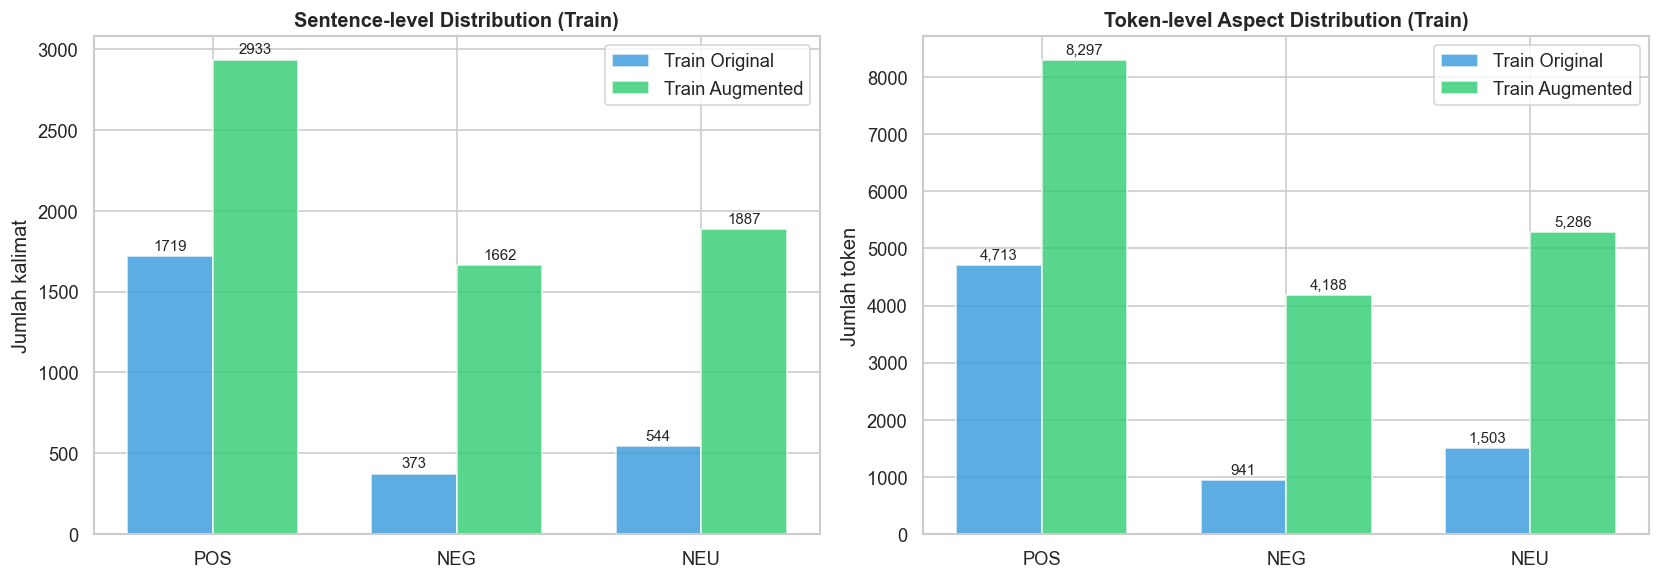

In [8]:
# Visualisasi perbandingan (train set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentence-level
categories = ['POS', 'NEG', 'NEU']
before_counts = [len(has_pos), len(has_neg), len(has_neu)]
after_counts = [len(has_pos_aug), len(has_neg_aug), len(has_neu_aug)]

x = range(len(categories))
width = 0.35
bars1 = axes[0].bar([i - width/2 for i in x], before_counts, width, label='Train Original', color='#3498db', alpha=0.8)
bars2 = axes[0].bar([i + width/2 for i in x], after_counts, width, label='Train Augmented', color='#2ecc71', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].set_title('Sentence-level Distribution (Train)', fontweight='bold')
axes[0].set_ylabel('Jumlah kalimat')
axes[0].legend()

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 20,
                 f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 20,
                 f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)

# Token-level
before_tokens = [label_counts[s] for s in categories]
after_tokens = [label_counts_aug[s] for s in categories]

bars3 = axes[1].bar([i - width/2 for i in x], before_tokens, width, label='Train Original', color='#3498db', alpha=0.8)
bars4 = axes[1].bar([i + width/2 for i in x], after_tokens, width, label='Train Augmented', color='#2ecc71', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories)
axes[1].set_title('Token-level Aspect Distribution (Train)', fontweight='bold')
axes[1].set_ylabel('Jumlah token')
axes[1].legend()

for bar in bars3:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                 f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                 f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [9]:
# Validasi: cek semua augmented train samples punya format yang benar
errors = 0
for i, d in enumerate(augmented_data):
    if len(d['tokens']) != len(d['labels']):
        print(f'ERROR sample {i}: tokens({len(d["tokens"])}) != labels({len(d["labels"])})')
        errors += 1
    if len(d['tokens']) < 2:
        print(f'ERROR sample {i}: too short ({len(d["tokens"])} tokens)')
        errors += 1
    valid_labels = {'O', 'B-POS', 'B-NEG', 'B-NEU', 'I-POS', 'I-NEG', 'I-NEU',
                    'E-POS', 'E-NEG', 'E-NEU', 'S-POS', 'S-NEG', 'S-NEU'}
    for lab in d['labels']:
        if lab not in valid_labels:
            print(f'ERROR sample {i}: invalid label "{lab}"')
            errors += 1

if errors == 0:
    print(f'Validasi OK — semua {len(augmented_data)} augmented train samples valid')
    print(f'Val set: {len(val_data)} samples (original, tidak divalidasi ulang)')
else:
    print(f'\nDitemukan {errors} error!')

Validasi OK — semua 4290 augmented train samples valid
Val set: 368 samples (original, tidak divalidasi ulang)


### 6. SIMPAN DATA AUGMENTED

In [10]:
# Shuffle augmented train data
random.shuffle(augmented_data)

# Save augmented TRAIN set
with open(OUTPUT_TRAIN_PATH, 'w', encoding='utf-8') as f:
    json.dump(augmented_data, f, ensure_ascii=False, indent=2)

# Save original VAL set
with open(OUTPUT_VAL_PATH, 'w', encoding='utf-8') as f:
    json.dump(val_data, f, ensure_ascii=False, indent=2)

train_size = os.path.getsize(OUTPUT_TRAIN_PATH) / (1024**2)
val_size = os.path.getsize(OUTPUT_VAL_PATH) / (1024**2)

print(f'Saved augmented train: {OUTPUT_TRAIN_PATH}')
print(f'  Size: {train_size:.1f} MB | Samples: {len(augmented_data)}')
print(f'\nSaved original val: {OUTPUT_VAL_PATH}')
print(f'  Size: {val_size:.1f} MB | Samples: {len(val_data)}')
print(f'\nSummary:')
print(f'  Original total : {len(data)} samples')
print(f'  Train (orig)   : {n_original} samples')
print(f'  Train (aug)    : {len(augmented_data)} samples (+{len(augmented_data)-n_original})')
print(f'  Val (untouched): {len(val_data)} samples')
print(f'  NEG copies     : +{n_neg_added} (x{NEG_MULTIPLIER})')
print(f'  NEU copies     : +{n_neu_added} (x{NEU_MULTIPLIER})')

Saved augmented train: d:\Kuliah\TA\Notebook\data\processed\train_data_bieos_augmented_train.json
  Size: 3.4 MB | Samples: 4290

Saved original val: d:\Kuliah\TA\Notebook\data\processed\train_data_bieos_val.json
  Size: 0.2 MB | Samples: 368

Summary:
  Original total : 2451 samples
  Train (orig)   : 2083 samples
  Train (aug)    : 4290 samples (+2207)
  Val (untouched): 368 samples
  NEG copies     : +1119 (x3)
  NEU copies     : +1088 (x2)
